---
title: "Basic mechanisms"
author: "Kevin Duffy"
bibliography: ../bibliography.bib
---

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/triaduct/offshoregeotechnics/blob/main/notes/4-2_mechanisms-sand.ipynb){target="_blank"} <nbsp>

First, we'll explore the mechanisms that affect the response of sand to penetrometers and piles. To do so, we will first focus on the continuous penetration of a fully displacing closed-ended pile—comparing its response relative to a much smaller CPT cone. After that we'll explore open-ended piles, focussing on the additional effect that plugging has on the axial response.

# Closed-ended piles
## Base resistance
One of the first sets of well-instrumented pile tests (particularly with radial stress sensors) came from tests on the so-called Imperial College Pile (ICP) at Labenne, where @lehaneExperimentalInvestigationsPile1992 showed that the pile base resistance $q_b$ of a jacked pile was approximately equal to the measured cone resistance $q_c$ from a CPT during installation.

![Measured pile base resistances at Labenne (LB) compared to CPT cone resistance [@lehaneExperimentalInvestigationsPile1992]](pics/axial/lehane92-fig6-2.JPG){#fig-labenne width=40%}


This is in some way unsurprising: the CPT also follows a similar mode of installation compared to a pile after all. But what's actually going on underneath a CPT or a pile during penetration? 

During this process, there's a whole load of changes going on underneath the pile base. Soil is being displaced or forced away from the pile, increasing the radial stresses (horizontal stresses) acting on the pile. As well as that, sand is not only densifying underneath pile base, but also crushing—turning into a tightly compacted, very fine sand.

::: {#fig-base-mechanisms layout-ncol=3}

![Schematic explanation [@yangSandGrainCrushing2010]](pics/axial/yang10-qb-framework.png){#fig-yang-framework}

![Photo from digital image correlation (DIC) tests by @tovar-valenciaExperimentalMeasurementParticle2023](pics/axial/tovar-valencia-et-al_2022_crushing.png){#fig-labenne}

![Video from DIC tests showing slow, crushing of particles during penetration [@tovar-valenciaExperimentalMeasurementParticle2023]](pics/axial/tovar-valencia-et-al_2022_supp-mat.mp4){#fig-tv-video width=100%}

Examples of soil crushing underneath the base of a CPT/conical pile (click to expand)
:::


::: {.callout-tip title="Does it make a difference if it's a conical tip or flat tip?" collapse="true" }
In terms of base resistance, *probably* not—at least at a macroscopic level. Underneath a flat-bottomed pile, a "nose cone" of densified, highly crushed sand forms (@whiteDisplacementStrainPaths2004, @fig-nose-cone). Constant shearing along the edges of this nose still leads to slip failures occurring along the edges, meaning soil still passes up along the pile.

![Nose cone underneath a model pile installed in a calibration chamber](pics/axial/dirk-de-lange-nose-cone.JPG){#fig-nose-cone}

:::

### Accounting for scale effects
Inevitably, the amount of soil that is disturbed by the pile is going to be dependent on the pile's diameter. As a result, a pile has a **sensing distance** and **development distance** ([@fig-tehrani18]), describing the zone of influence around the pile tip. 

As an example, if a strong layer is underlying a weak layer, the pile will begin to sense the strong layer before it reaches the actual interface. This is because the pile's base resistance depends not just on the soil at precisely the same level as the pile base itself, but also on the soil below it--known as the sensing distance.

Conversely, the weak layer will also continue to affect the pile base resistance until it gets sufficiently deep into the sand layer--this is known as the development distance. 

The lengths of the sensing and development distances are of course dependent on the pile diameter, but they're also dependent on the relative strengths of the layers themselves [@boulangerInverseFilteringProcedure2018]. 

![Influence of multi-layered penetration on a CPT [@whiteDisplacementStrainPaths2004]](pics/axial/tehrani18.png){#fig-tehrani18 width=80%}


To model this spatially dependent behaviour, so-called **averaging methods** have been developed. These methods are particularly common in CPT-based design methods, where the CPT measurements have to be scaled up to the size of a pile in order to predict the base resistance.

In the Netherlands and worldwide, the Koppejan 4D/8D method [@vanMierlo] is one of the most well known averaging methods. However recent studies [@bittarApplicationNewQc2022; @deBoorderSW22; @duffyBaseResistanceScrew2024] have shown that the Koppejan method isn't so accurate in accounting for size differences between a CPT and a pile.

::: {.callout-note}
Often the output from an averaging method algorithm is referred to as $q_{c,avg}$, but be aware that this does not refer to the arithmetic average! The latest Unified method in sand instead refers to this output as $q_p$.
:::

With this in mind, @boulangerInverseFilteringProcedure2018 proposed a new averaging method known as the **filter method**. The filter method corrects for the influence of surrounding layers on the base resistance by using two weightings: one accounting for the distance from the pile base, and the second accounting for differences in soil strength.

Nevertheless, the method by @boulangerInverseFilteringProcedure2018 was developed specifically for liquefaction assessment, not for pile resistance. While it gives improved understanding of the pile base resistance (relative to a CPT), several minor adjustments have been proposed to the method (e.g. @bittarApplicationNewQc2022, @tianInfluenceSoilLayering2025).

::: {.callout-tip title="A worked example from the calibration chamber in Deltares" collapse="true"}

Take for instance the calibration chamber tests performed by @deLangeNAMReport in the calibration chamber in Deltares. A multi-layered scenario was created with five weak clay layers within a thick layer of sand. A "true" $q_c$ value was established for both the clay and sand through separate tests.

Therefore, when a CPT ($D=35mm$) penetrated through this multi-layered sample, it would indicate what layers actually affect the CPT's measurement when compared to the true $q_c$ profile. You can see that the filter method models the measured CPT resistances quite well, and certainly much better compared to the Koppejan method.

![Calibration chamber set-up by @deLangeNAMReport](pics/axial/delange18_calib-chamber.png){#fig-calib-chamber width=40%}

You can also check this with the code below. It also includes a hypothetical scenario of a penetrometer with a diameter of `5*d_cpt`, whilst also assuming that the filter method by @deBoorderSW22 is the ground truth.

Since this hypothetical penetrometer is much larger than the original CPT, it can barely detect the individual contribution of each weak layer. Instead it virtually spatially averages the whole unit, sensing a cone resistance of just under 1 MPa.

As an aside: since the stress conditions in a calibration chamber are much different to real-life conditions, the measured cone resistance are also not "typical" cone resistances.

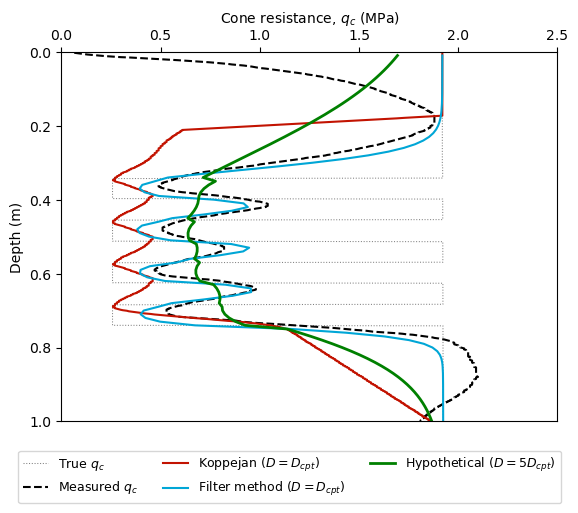

In [2]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import sys

# sys.path.append("..")
# !pip install git+https://github.com/triaduct/offshoregeotechnics.git@main # Use this code to add offshoregeotechnics to your Python library 

from utils import averaging_methods

fig = plt.figure()
ax = fig.gca()

# Measurements from calibration chamber as well as existing calcs (to reduce computational time) are stored in calib-chamber.csv
cpt = pd.read_csv("data/calib-chamber.csv")
d_cpt = 36E-3 # Original diameter of the CPT cone = 36mm
ax.plot(cpt.qc,cpt.z*-1,label="True $q_c$",lw=0.75,c="gray",ls=":")       # True qc value if layer was infinitely thick
ax.plot(cpt.qc_meas,cpt.z_meas*-1,label="Measured $q_c$",c="k",ls="--")   # Measured by a CPT with diameter D_cpt
ax.plot(cpt.qc_koppejan,cpt.z_koppejan*-1,label="Koppejan ($D=D_{cpt}$)",c="#C21301")  # Koppejan method (D = D_cpt)
ax.plot(cpt.qc_filter,cpt.z_filter*-1,label="Filter method ($D=D_{cpt}$)",c="#00A6D6") # Filter method by De Boorder, 2022 (D = D_cpt)

# ===============================
# Consider a hypothetical scenario, with a pile diameter X times the original CPT diameter
X = 5  # Hypothetical diameter = X*d_cpt
# ===============================

# Arrays for storing data
qc_avg_deb = []
z_lst = []
for end_depth in np.arange(-1.5,0,0.01):    # Performing calculation at these depths
    # qc_avg_deb.append(averaging_methods.lcpc(cpt, X*d_cpt, end_depth))   # Alternatively: feel free to consider the LCPC 1.5D method!
    qc_avg_deb.append(averaging_methods.de_boorder(cpt, X*d_cpt, end_depth))
    z_lst.append(end_depth)
ax.plot(qc_avg_deb,np.array(z_lst)*(-1),label=f"Hypothetical ($D=$" +  str(X) + "$D_{cpt}$)",c="green",lw=2)

# Other plot settings
ax.set_xlabel("Cone resistance, $q_c$ (MPa)")
ax.set_ylabel("Depth (m)")
ax.legend(fontsize=9,ncol=3,loc="center left",bbox_to_anchor=(-0.1,-0.15))
ax.set_xlim(0,2.5)
ax.set_ylim(0,1)
ax.tick_params(labelbottom=False,labeltop=True)
ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks_position('top')
ax.invert_yaxis()

Feel free to change the code yourself in Google Colab! [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/triaduct/offshoregeotechnics/blob/main/notes/4-2_mechanisms-sand.ipynb){target="_blank"} <nbsp>
:::

## Shaft resistance
Through model tests on instrumented piles, @lehaneMechanismsShaftFriction1993, @chowInvestigationsBehaviourDisplacement1997 and @limTimeEffectsShaft2015 have shown that the shaft friction $q_s$ on a displacement pile obeys Coulomb's Law where:

$$
q_s = \sigma'_{rf} \tan(\delta_f) = (\sigma'_{rc} + \Delta \sigma'_{rd}) \tan(\delta_f)
$$

where $\sigma'_{rf}$ is the radial effective stress at peak friction, $\delta_f$ is the ultimate constant volume interface friction, $\sigma'_{rc}$ is the stationary radial effective stress and $\Delta \sigma'_{rd}$ is the increase in radial effective stress under axial loading that is caused by dilation.


### Stationary radial effective stress $\sigma'_{rc}$
@vesicTestsInstrumentedPiles1970 and @lehaneExperimentalInvestigationsPile1992 (among others), observed that the radial effective stress $\sigma'_{rf}$ of a jacked or driven pile reduces as the distance from the pile tip $h$ increases, like shown in @fig-labenne-qs. 

![Measured radial stresses from Labenne (adapted from @lehaneExperimentalInvestigationsPile1992) ](pics/axial/labenne-qs.PNG){#fig-labenne-qs width=60%}

This phenomenon is known as **friction fatigue** and is caused by the contraction of sand at the pile-soil interface, which in turn reduces the far-field radial stresses acting on the pile (@fig-white-friction-fatigue). The amount of friction fatigue continues to develop as the pile penetrates deeper and deeper and so elevations that have experienced more loading cycles (caused by pile hammering or jacking increments) will have reduced radial effective stresses compared to horizons further down the pile.

The contraction stiffness of the sand, or the degree at which it wants to contract, also depends on the pile diameter [@jardineMeasurementStressesClosedended2013]. As a result (and as we will see in the next section), design methods often express friction fatigue as a function of $h/D$—in other words: the normalised distance from the pile base. 

::: {#fig-friction-fatigue layout-ncol=2}

![Close-up picture of the penetrometer-soil interface by @arshadExperimentalStudyCone2014](pics/axial/arshad-friction-fatigue.png){#fig-arshad-friction-fatigue}

![Mechanism proposed by @whiteDisplacementStrainPaths2004, where Zone B is the area of highly crushed soil](pics/axial/white-bolton-friction-fatigue.PNG){#fig-white-friction-fatigue width=60%}

Insights into the mechanisms causing friction fatigue
:::


### Interface friction angle $\delta$
As with any interface between two materials, understanding the interaction between the two materials is a key step in understanding the frictional resistance between them. For this, the interface frction angle $\delta_f$ is used, which is a function of the pile roughness and soil properties, where $\delta_f = \phi'$ represents a perfectly rough interface, while $\delta_f = 0$ represents a perfectly smooth interface. 

Somewhat intuitively, initial studies and design methods (e.g. @jardineFrictionCoefficientsPiles1992) suggested that $\delta_f$ varies with the mean particle diameter $D_{50}$, or more specifically, the relative roughness of the interface compared to the particle size). 

However, several studies (e.g. @yangSandGrainCrushing2010, @hoLargedisplacementInterfaceShear2011, @liuUnifiedDatabaseRing2019) have shown that this is less likely to be the case, largely because of the high levels of particle breakage underneath the pile tip, which passes up along the pile-soil interface (@fig-friction-fatigue). 

Nevertheless, as @fig-delta-f shows, there's quite some variation in ring shear tests performed in the laboratory—partly because of the influence of fines content, interface roughness and shearing rate and so site-specific tests are generally recommended for determining $\delta_f$.

![Variation in $\delta_f$ with mean particle size $D_{50}$ [@liuUnifiedDatabaseRing2019]](pics/axial/liu19-fig3.jpg){#fig-delta-f width=60%}


### Change in radial stress under loading $\Delta \sigma'_{rd}$
The restraint to dilation at the pile shaft during pile loading provided by the surrounding sand leads to an increase in radial stress on the pile shaft $\Delta \sigma'_{rd}$ and hence to the peak shaft friction. This increase can be expressed from cavity expansion theory by $\Delta \sigma'_{rd} = 4G · \Delta r / D$ (@lehaneShaftCapacityDriven1994), where $G$ is the shear modulus and $y$ is the dilation of the sand at the shaft interface. 

Since the degree of dilation is inversely proportional to the pile diameter $D$, dilation is usually only significant for small diameter piles. Therefore, this dilation component becomes very important when extrapolating the results of small-scale laboratory tests (depending on the relative mean particle size and pile diameter) to full-scale piles.

::: {.callout-note}
The influence of $\Delta \sigma'_{rd}$ on the friction sleeve resistance $f_s$ is also one of the reasons why $f_s$ is not often used in CPT-based design methods. Measurement inaccuracies is also another reason (@lunneConePenetrationTesting1997).
:::

### Residual stresses
Driving a precast pile generates a substantial amount of stresses in the pile and the surrounding soil. Under each blow, the pile body and soil beneath the pile base compress and 
deform, partially rebounding after each blow. When the pile rebounds upwards, the stresses relax underneath the pile base whilst negative shear stresses mobilise along the pile shaft (@fig-amaliahaven-res-loads). 

Eventually, an equilibrium is reached between the upward and downward stresses--with all these stresses being referred to as **residual stresses**. These residual stresses remain on the pile, even with no load being applied on the top of the pile

For design, it's not necessary to know the amount of residual stresses, after all, it's more important to understand the relative response of the pile to an applied load. Nevertheless, residual loads are important for interpreting pile tests where knowing the absolute magnitude of $q_b$ and $q_s$ is needed, especially when compared to site investigation tests. 

::: {#fig-residual-loads layout-ncol=2}

![Response of the pile underneath each hammer blow](pics/axial/amaliahaven-residual-loads1.PNG){#fig-res-load-mech width=50%}

![Measurements of residual loads At Amaliahaven from after pile driving, but before load testing](pics/axial/amaliahaven-residual-loads2.PNG){#fig-amaliahaven-res-loads width=100%}

Residual loads creating by the installation of a precast pile
:::


# Open-ended piles
Open-ended piles (also known as tubular piles) are far and beyond the most common pile type offshore. There are several reasons for this, although this largely comes down to their ease of installation and cost of manufacturing when compared to driven piles.

Generally, monopiles have diameters of 4-6m, reaching up to 15m for "XXL" monopiles. A key design parameter in the structural engineering phase is the diameter-to-wall-thickness ratio $D/t$. This ratio is typically around 40-80, and is currently limited at 120 in most structural design codes. 

::: {#fig-friction-fatigue layout-ncol=2}

![Monopile just after fabrication at the SIF facility in the port of Rotterdam [(source)](https://www.offshorewind.biz/2024/11/29/sif-produces-first-empire-wind-1-monopile-in-netherlands/)](pics/axial/sif-monopile.jpg){width=70%}

![Installation of a monopile at Thor offshore wind farm in Denmark  [(source)](https://offshore-channel.com/twd-releases-white-paper-on-innovating-methods-for-monopile-installation-to-meet-installation-targets)](pics/axial/iqip-installation.jpg)
:::

## Plug resistance
All of the mechanisms mentioned up until now also affect tubular piles. However, one key mechanism that distinguishes open-ended piles from closed-ended piles is **plugging**. 

Plugging refers to the process by which soil enters and accumulates inside a tubular pile, forming a column of soil that stops more soil from entering the pilepile. This affects the pile’s behaviour during both installation and operational loading, since plugging also displaces soil around the pile as it penetrates through the ground. 

This means the open-ended piles have both an **annular resistance** $q_{ann}$ and a **plug resistance** $q_{plug}$ (which includes the inner shaft resistance). As we will see in the next chapter, design methods often lump both of these into the pile's base resistance where $q_b = q_{ann} + q_{plug}$.

::: {#fig-plugging layout-ncol=3}

![Fully coring ($PLR = 1$)](pics/axial/plug_coring.png){#fig-coring}

![Partially plugged ($0 \le PLR \le 1$)](pics/axial/plug_partial.PNG){#fig-partial-plug}

![Fully plugged ($PLR = 0$)](pics/axial/plug_full.PNG){#fig-full-plug}

Plugging in an open-ended pile
:::


::: {.callout-note title="Quantifying the amount of plugging"}
The amount of the plugging that has occurred can be quantified in a few different ways:

* The **plug length ratio** ($PLR$) is a measurement *after* pile installation, where the elevation of the plug inside the tubular pile is measured directly, i.e.:  

$$
PLR = \frac{L_p}{L}
$$ {#eq-plr-pile}

* The **incremental filling ratio** ($IFR$) is a measurement of the change in plug height over a given penetration $\Delta L_p$. It is therefore a measurement made *during* pile installation: 

$$
IFR = \frac{\Delta L_p}{\Delta L}
$$ {#eq-ifr-pile}

* The **final filling ratio** ($FFR$) is the average IFR over the final three pile diameters of installation.

:::

### Why does plugging occur?
A series of different mechanisms occurs when a pile plugs (@fig-plugging-mechanisms). At first, soil freely enters the pile. The internal stress state is low and so the plug height grows at nearly the same rate as the penetration depth ($IFR = 1$). Shear stresses acting on the inside of the pile are comparable to those acting outside of the pile.  

Yet shaft friction is also mobilising along the inside of the pile wall during this process, especially towards the bottom of the pile. As this friction continues to build up, stress chains or arches around the inside of the pile. Eventually, this zone of influence becomes so large that the the soil eventually locks up, with the arches being strong enough to resist further intrusion of soil into the pile. At this stage, the pile acts fully plugged ($IFR = 0$) and forces soil around the pile. 

::: {#fig-plugging-mechanisms layout-ncol=2}

![@cerfontaineStudyParticleScale2023](pics/axial/plugging-cerfontaine.png){#fig-plugging-cerfontaine width=70%}

![@liAnalysisPluggingEffect2021](pics/axial/liu21-fig20.JPG){#fig-plugging-li}

Summaries of two Discrete Element Method studies of plugging in open-ended piles
:::

Just like a closed-ended pile, a plugged open-ended pile has a nose "cone" of dense sand towards the bottom ([@fig-plugging-cerfontaine]). This means the base response of a fully plugged pile is very similar to a closed-ended pile during installation. Therefore, the resistances mobilised by the plug are similar to the CPT cone tip resistance when $IFR=0$ ([@fig-lehane-gavin-qplug]). 

![Dependence of $q_{plug} / q_c$ on $IFR$ during tests on jacked model piles [@lehaneBaseResistanceJacked2001]](pics/axial/lehane-gavin-qplug.PNG){#fig-lehane-gavin-qplug width=60%}



::: {.callout-tip title="**Side note:** How do we measure the contribution of the pile plug during experiments?" collapse="true"}
Strain sensors measure how much the pile shaft compresses under an axial load—which is in turn correlated to how much shaft resistance each soil layer gives. 

Measuring the shaft resistance of a closed-ended pile is relatively straightforward. But for an open-ended pile it's difficult to separate the plug and external shaft friction contributions from one another, since both of these simultaneously affect how much the steel tube compresses under loading.

To do so, a **twin-walled pile** is often used. Strain sensors attached to the external tube measure solely the external shaft friction, whereas strain sensors attached to the inner tube measure noly the contribution of the soil plug. 

While this is of course an optimal solution to quantifying the resistance components individually, often this may not be possible due to costs and time constraints. 

::: {#fig-twin-walled-piles layout-ncol=2}

![Twin-walled model pile setup by @igoeShaftCapacityOpenended2011](pics/axial/twin-walled-pile.PNG){#fig-twin-walled-pile-igoe width=60%}

![Assembly of a full-scale twin-walled pile by @hanAxialResistanceOpenended2020](pics/axial/twin-walled-pile-han.PNG){#fig-twin-walled-pile-han width=80%}

Two examples of twin-walled piles for field test experiments
:::

:::

### When does plugging occur?
The degree of plugging one would expect during installation is strongly dependent on several factors. Crucially, plugging seldom occurs during the installation of driven tubular piles offshore. There's a couple of reasons for this: 

1. The relative size pile-to-particle diameter significantly reduce the likelihood of the locked-up nose cone from forming. Generally, for piles greater than 1.5m in diameter, it is assumed that plug formation won't occur. 
2. The acceleration of pile wall relative to the (static) pile plug creates a phase shift or "slippage" under each hammer blow.

With these factors in mind, there are also ways to mitigate the likelihood of plugging. One method includes water fluidisation, something which is currently being trialled with vibratory installation in the Dutch North Sea Sector ([GBM Works](https://www.gbmworks.com/copy-of-vibrojet)). Another solution is a driving shoe (@fig-driving-shoe), which increases the thickness of the pile tip annulus and causes a reduction in horizontal stresses as the soil flows past the shoe [@denicolaPluggingBehaviourDriven1997; @finlayPressinpilingInstallationInstrumented2001].

![Driving shoe at the base of an open-ended pile [@finlayPressinpilingInstallationInstrumented2001]](pics/axial/finlay01-driving-shoe.jpg){#fig-driving-shoe width=50%}

::: {.callout-note}
It's important to realise the physical differences between **installation response** and **operational response** (in other words, the dynamic vs static response). 

While plugging isn't necessarily a concern for large-diameter piles *during installation*, in the next section we'll see that the plug response can be quite different under slower, operational loading. 
:::

### What are the other implications of plugging?
Once the plug is fully formed, the pile essentially behaves just like a closed-ended pile, displacing the soil around the pile base. As a result, radial stresses will also build up around the pile (@fig-plugging-radial-stress), thus increasing the external shaft resistance. 

![Influence of plugging on the radial stresses around the pile](pics/axial/plugging-alternative.png){#fig-plugging-radial-stress width=70%}


## Annular resistance
During continuous penetration, the pile annulus behaves no different to a cone penetrometer, since they both have relatively similar dimensions (typical wall thickness of a monopile $\approx$ 80mm. As a result, $q_{ann}$ is independent of the plugging response during installation, mobilising resistance similar to the CPT $q_c$ value (@fig-ifr-qann). 

![Dependence of $q_{ann} / q_c$ on $IFR$ during tests on jacked model piles [@lehaneBaseResistanceJacked2001]](pics/axial/lehane-gavin-qann.PNG){#fig-ifr-qann width=50%}
